# H2O AutoML Lending Club Demo

This notebook walks through the machine learning pipeline for binary classification with H2O. We will use the Lending Club dataset, which includes loan data, to predict whether or not a borrower is likely to default.

**Steps include:**

Part I

* Importing a dataset
* Basic dataframe manipulations
* Creating a target (response column)
* Feature preprocessing & engineering
* Splitting the data into training and validation sets
* Building models (GLM & GBM)
* Evaluating model performance

[Part 2](#part2)
* Running a grid search
* Running [AutoML](#automl) (H2O's Automatic Machine Learning Algorithm)

The dataset used in this tutorial is available for download on s3 [here](https://s3.amazonaws.com/h2o-training/workshops/ComputeFest/LoanStats3a.csv). The original dataset comes from the [Lending Club](https://www.lendingclub.com/info/download-data.action), a peer-to-peer lending platform. 

## Start an H2O Cluster

In [17]:
%matplotlib inline
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,2 mins 44 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.9
H2O cluster version age:,2 days
H2O cluster name:,H2O_from_python_navdeepgill_6z2wg7
H2O cluster total nodes:,1
H2O cluster free memory:,3.432 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


## Import the Dataset

In [18]:
destination_frame_name = 'loan_modeling_table.hex'
loan_stats = h2o.import_file(path="../data/LoanStats3a.csv", destination_frame=destination_frame_name)

Parse progress: |█████████████████████████████████████████████████████████| 100%


We can verify that this H2Oframe now exists in the Java backend

In [19]:
h2o.ls()

,key
0,Key_Frame__upload_a10e5a4420373fdf60b9f59c51f7...
1,loan_modeling_table.hex
2,py_10_sid_8fbc
3,py_11_sid_8fbc
4,py_2_sid_8fbc
5,py_3_sid_8fbc
6,py_4_sid_8fbc
7,py_5_sid_8fbc
8,py_6_sid_8fbc
9,py_7_sid_8fbc


Get a summary of your dataset:

In [20]:
loan_stats.describe()

Rows:42538
Cols:52




,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
type,int,int,int,int,real,enum,enum,real,enum,enum,enum,enum,enum,real,enum,time,enum,enum,string,enum,enum,enum,enum,enum,real,int,time,int,enum,enum,int,int,int,enum,int,enum,real,real,real,real,real,real,real,real,real,time,real,time,time,int,enum,int
mins,54734.0,70473.0,500.0,500.0,0.0,,,15.67,,,,,,1896.0,,1180656000000.0,,,NaN,,,,,,0.0,0.0,-757382400000.0,0.0,,,1.0,0.0,0.0,,1.0,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1196467200000.0,0.0,1196467200000.0,1177977600000.0,0.0,,1.0
mean,664579.8523098624,825702.5511696247,11089.722581403548,10821.585752909366,10139.830601160369,,,322.6256186669802,,,,,,69136.55642025816,,1285641609930.6453,,,NaN,,,,,,13.373043140942753,0.15244906601420974,854295612817.0144,1.0814237989930833,,,9.343951442149342,0.05815649555356891,14297.860914540966,,22.124405966216536,,329.41112354531566,327.08996544022585,11651.753137029318,10948.580165745856,9368.080581873754,2209.0491120253905,1.4587326863798291,73.16471900701595,9.076818272012224,1360320371318.1946,2552.6072568473023,1381323445229.3428,1385971917105.1707,0.0,,1.0
maxs,1077501.0,1314167.0,35000.0,35000.0,35000.0,,,1305.19,,,,,,6000000.0,,1322697600000.0,,,NaN,,,,,,29.99,13.0,1225497600000.0,33.0,,,47.0,5.0,1207359.0,,90.0,,17749.51,17749.51,56809.05162878322,56475.05,35000.03,21809.05,208.819529958391,29623.35,7002.19,1433116800000.0,36115.2,1438387200000.0,1435708800000.0,0.0,,1.0
sigma,219302.21931883864,279540.90563504875,7410.938390546603,7146.914675006228,7131.686448676308,,,208.92806900008023,,,,,,64096.34971887445,,31759283733.073757,,,NaN,,,,,,6.726314901729999,0.5124064850165572,216068688522.3565,1.5274548353027584,,,4.496273875691112,0.24571314065050043,22018.44100968324,,11.592811337332776,,1417.545686132105,1409.613733492644,8555.46989933326,8486.980394028196,6777.119818605451,2502.528240924457,7.572756175925983,612.260185350403,149.08682302572694,47801906399.73409,4380.384766172414,69074077358.5791,49253773579.29899,0.0,,0.0
zeros,0,0,0,0,233,,,0,,,,,,0,,0,,,0,,,,,,206,37771,4,19657,,,0,40130,1119,,0,,38972,38972,26,304,86,83,40214,38357,39033,0,95,0,0,42390,,0
missing,3,3,3,3,3,3,3,3,3,3,3,3,3,7,3,3,3,3,3,3,3,3,3,3,3,32,32,32,3,3,32,32,3,3,32,3,3,3,3,3,3,3,3,3,3,86,3,36281,7,148,3,3
0,1077501.0,1296599.0,5000.0,5000.0,4975.0,36 months,10.65%,162.87,B,B2,,10+ years,RENT,24000.0,VERIFIED - income,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,27.65,0.0,1985-01-01 00:00:00,1.0,,,3.0,0.0,13648.0,83.7%,9.0,f,0.0,0.0,5861.071414249,5831.78,5000.0,861.07,0.0,0.0,0.0,2015-01-01 00:00:00,171.62,,2015-01-01 00:00:00,0.0,,1.0
1,1077430.0,1314167.0,2500.0,2500.0,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,VERIFIED - income source,2011-12-01 00:00:00,Charged Off,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077430,Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when

## Overview of H2OFrame Manipulation

H2O's Python API is designed to imitate native python conventions and whenever possible use the same naming conventions Python and Pandas users would expect. 

In this section we will cover the following basic H2O frame manipulations:

* selecting/subsetting columns
* selecting/subsetting rows
* combining columns
* converting between an H2O and Pandas dataframe

More documentation on munging can be found [here](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-munging.html#).

#### Subsetting & Selecting

Here we cover how to select individual columns and rows or subsets the data based on a combination of columns and rows.

In [21]:
# select a column by name (where the column name is `term`)
loan_stats[:, 'term'] # equivalent to train['term']

term
36 months
60 months
36 months
36 months
60 months
36 months
60 months
36 months
60 months
60 months


In [22]:
# select a column by index 
loan_stats[:,5] # equivalent to loan_stats[5]

term
36 months
60 months
36 months
36 months
60 months
36 months
60 months
36 months
60 months
60 months


In [23]:
# select a few columns by name 
loan_stats[:,['id', 'loan_amnt', 'term']] # equivalent to loan_stats[['id', 'loan_amnt', 'term']]

id,loan_amnt,term
1.0775e+06,5000,36 months
1.07743e+06,2500,60 months
1.07718e+06,2400,36 months
1.07686e+06,10000,36 months
1.07536e+06,3000,60 months
1.07527e+06,5000,36 months
1.06964e+06,7000,60 months
1.07205e+06,3000,36 months
1.0718e+06,5600,60 months
1.07157e+06,5375,60 months


In [24]:
# select rows by index
loan_stats[2,:]

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.07718e+06,1.31352e+06,2400,2400,2400,36 months,15.96%,84.33,C,C5,,10+ years,RENT,12252,not verified,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,,small_business,real estate business,606xx,IL,8.72,0,2001-11-01 00:00:00,2,,,2,0,2956,98.5%,10,f,0,0,3003.65,3003.65,2400,603.65,0,0,0,2014-06-01 00:00:00,649.91,,2015-06-01 00:00:00,0,,1


In [25]:
# selecting rows by an index range
loan_stats[2:5,:]

id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.07718e+06,1.31352e+06,2400,2400,2400,36 months,15.96%,84.33,C,C5,,10+ years,RENT,12252,not verified,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077175,,small_business,real estate business,606xx,IL,8.72,0,2001-11-01 00:00:00,2,,,2,0,2956,98.5%,10,f,0,0,3003.65,3003.65,2400,603.65,0,0,0,2014-06-01 00:00:00,649.91,,2015-06-01 00:00:00,0,,1
1.07686e+06,1.27718e+06,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200,VERIFIED - income source,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1076863,"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time.",other,personel,917xx,CA,20,0,1996-02-01 00:00:00,1,35,,10,0,5598,21%,37,f,0,0,12226.3,12226.3,10000,2209.33,16.97,0,0,2015-01-01 00:00:00,357.48,,2015-01-01 00:00:00,0,,1
1.07536e+06,1.31175e+06,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,1 year,RENT,80000,VERIFIED - income source,2011-12-01 00:00:00,Current,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1075358,"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other bills. I've always been a good payor but have found myself needing to make adjustments to my budget due to a medical scare. My job is very stable, I love it.",other,Personal,972xx,OR,17.94,0,1996-01-01 00:00:00,0,38,,15,0,27783,53.9%,38,f,1168.04,1168.04,2767.64,2767.64,1831.96,935.68,0,0,0,2015-06-01 00:00:00,67.79,2015-07-01 00:00:00,2015-06-01 00:00:00,0,,1


In [26]:
# select by specified row and column
loan_stats[1:3,['member_id','term']]

member_id,term
1.31417e+06,60 months
1.31352e+06,36 months


#### Adding New Columns or New Rows

In [27]:
small_frame = loan_stats[1:3,['loan_amnt','installment']]
single_col_frame = loan_stats[1:3,'grade']

# combine these two equal sized frames
small_frame.cbind(single_col_frame) 

loan_amnt,installment,grade
2500,59.83,C
2400,84.33,C


In [28]:
# for appending rows you can use .rbind()
small_frame.rbind(small_frame)

loan_amnt,installment
2500,59.83
2400,84.33
2500,59.83
2400,84.33


#### Converting Between Pandas and H2O Dataframes

In [29]:
# convert an h2oframe to pandas frame (make sure H2OFrame fits in memory!)
pandas_small_frame = small_frame.as_data_frame()
print(type(pandas_small_frame))
pandas_small_frame

<class 'pandas.core.frame.DataFrame'>


,loan_amnt,installment
0,2500,59.83
1,2400,84.33


In [30]:
# converting back to an h2o frame
back_to_h2o_frame = h2o.H2OFrame(pandas_small_frame)
print(type(back_to_h2o_frame))
back_to_h2o_frame

Parse progress: |█████████████████████████████████████████████████████████| 100%
<class 'h2o.frame.H2OFrame'>


loan_amnt,installment
2500,59.83
2400,84.33


## Creating a Target to Predict

Depending on the stage of your data science project, your data may or may not have a target included (if you go to Kaggle for example the data will include a target (aka response column). In this case our data does not have a target so we will create one. 

Given that we want to predict if a borrower will default or not, which column could we use to create a target (aka repsonse column)?

Take a look at the column names in the list below. Does anything look useful?

In [31]:
loan_stats.columns

['id',
 'member_id',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'grade',
 'sub_grade',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'verification_status',
 'issue_d',
 'loan_status',
 'pymnt_plan',
 'url',
 'desc',
 'purpose',
 'title',
 'zip_code',
 'addr_state',
 'dti',
 'delinq_2yrs',
 'earliest_cr_line',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'initial_list_status',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_d',
 'last_pymnt_amnt',
 'next_pymnt_d',
 'last_credit_pull_d',
 'collections_12_mths_ex_med',
 'mths_since_last_major_derog',
 'policy_code']

What about loan_status? 

How could we take this multi-level column (aka feature) and convert it into a binary feature?

The following cells will show you how to:

* look at the unique levels in the `loan_status` column
* remove unwanted rows
* bin multiple levels into two levels 

In [32]:
# .table() gives you the frequency count of each unique level
loan_stats["loan_status"].table()

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


Let's also check for missing values. We see that there are three missing values in the column we would like to use as our target.

In [33]:
loan_stats['loan_status'].isna().sum()

3.0

Because this will be our response column if there are missing values we will want to remove the corresponding rows. First will create a boolean column indicating the missing values as 1s, then we will take the logical negation so the 1s become 0s and use that boolean column to create a subset of our data where we remove any rows with a missing response.

In [34]:
rows_with_missing_response = loan_stats['loan_status'].isna()
no_missing_values_response = rows_with_missing_response.logical_negation()

In [35]:
loan_stats = loan_stats[no_missing_values_response]
print('how many missing values do we have now:' , loan_stats['loan_status'].isna().sum())

how many missing values do we have now: 0.0


We see that some historic loans would no longer meet the Lending Club's credit policy.
Let's remove all loans that do not meet LC's credit policy

In [36]:
# .grep() allows you to search for string patterns within a column
doesnt_meet_credit_policy = loan_stats['loan_status'].grep(pattern = "Does not meet the credit policy.  Status:",
                                                     output_logical = True)

In [37]:
doesnt_meet_credit_policy.head(rows=2)

C1
0
0


In [38]:
# .logical_negation() flips 0 to 1 (Trues => False)
meets_credit_policy = doesnt_meet_credit_policy.logical_negation()
meets_credit_policy.head(rows=2)

not(C1)
1
1


Now that we removed applicants that would no longer meet the credit approval policy, let's take a look at what else should be removed.

In [39]:
loan_stats = loan_stats[meets_credit_policy]
loan_stats['loan_status'].table()

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16
Late (31-120 days),74


How would you subset your data to only include completed loans?

*Hint: "Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)" are ongoing loans.*

In [40]:
to_remove = ["Current", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)"]
loan_stats = loan_stats[loan_stats["loan_status"].isin(to_remove).logical_negation(), :]

In [41]:
loan_stats["loan_status"].table()

loan_status,Count
Charged Off,5435
Default,7
Fully Paid,30843


We are going to assume anyone who is late over 121 (corresponding to the `loan_status = Charged Off`) is going to default, so we will lump `Default` and `Charged Off` into the same bucket. This will leave us with only two levels Default and Fully Paid.

In [42]:
boolean_test_frame = ((loan_stats['loan_status'] == 'Charged Off')|(loan_stats['loan_status'] == 'Default'))
loan_stats['loan_status'] = boolean_test_frame.ifelse('Default','Fully Paid')

In [43]:
loan_stats['loan_status'].table()

loan_status,Count
Fully Paid,30843
Default,5442


Now that we have our target in the form we want, let's rename it to something more conclusive sounding `loan_result`.

In [44]:
loan_stats.set_name('loan_status', 'loan_result') 

In [45]:
loan_stats["loan_result"].head(rows=2)

loan_result
Fully Paid
Default


## Feature Preprocessing

From the variables we want to keep, which variables might need cleanup? Take a look at all the enum type columns.

Hint: Are there any enum columns that could be converted into numeric columns?

In [46]:
cat_col_index = loan_stats.columns_by_type(coltype='categorical')
loan_stats[cat_col_index].head(rows=1)

term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_result,pymnt_plan,desc,purpose,title,zip_code,addr_state,mths_since_last_delinq,mths_since_last_record,revol_util,initial_list_status,mths_since_last_major_derog
36 months,10.65%,B,B2,,10+ years,RENT,VERIFIED - income,Fully Paid,n,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,,,83.7%,f,


We can see that  `revol_util` has been parsed as enums, because of special characters, but should really be type numeric, because it holds numeric values.

In [47]:
loan_stats["revol_util"].head(rows=2)

revol_util
83.7%
9.4%


To do string cleaning/munging on a categorical/enum type column, you first have to covert that column to string type with `.ascharacter()`.

In [48]:
# .gsub allows you to replace by pattern, while .trim() allows you to remove leading and trailing white spaces.
loan_stats["revol_util"] = loan_stats["revol_util"].ascharacter()
loan_stats["revol_util"] = loan_stats["revol_util"].gsub(pattern = "%", replacement = "")
loan_stats["revol_util"] = loan_stats["revol_util"].trim() 
loan_stats["revol_util"] = loan_stats["revol_util"].asnumeric() 
loan_stats["revol_util"].head(rows = 2)

revol_util
83.7
9.4


Now that we have a numeric type column we can get a few statistics on this column such as min and max values.

In [49]:
print(loan_stats["revol_util"].na_omit().min())
print(loan_stats["revol_util"].na_omit().max())
# loan_stats["revol_util"].describe()

0.0
99.9


# Feature Engineering

What new features could we create from the features we currently have?

Let's create a new features called `credit_length_in_years`.
Note: H2O coverts the date columns to milliseconds since January 1, 1970 behind the scenes.

In [50]:
loan_stats["issue_d"].types

{'issue_d': 'time'}

In [51]:
print(loan_stats["issue_d"].head(rows=2))
print(loan_stats["issue_d"].year().head(rows=2))

issue_d
2011-12-01 00:00:00
2011-12-01 00:00:00


issue_d
2011
2011


In [52]:
loan_stats["earliest_cr_line"].head(rows=2)

earliest_cr_line
1985-01-01 00:00:00
1999-04-01 00:00:00


In [53]:
loan_stats["credit_length_in_years"] = loan_stats["issue_d"].year() - loan_stats["earliest_cr_line"].year()
loan_stats["credit_length_in_years"].head(rows=3)

credit_length_in_years
26
12
10


# How to Export to CSV

After you've finished your data and feature preprocessing, along with feature engineering you may want to download your dataset as a csv so that the next time you run this notebook you don't have to redo all the preprocessing steps.

In [54]:
# h2o.export_file(loan_stats,'preprocessed_loan_dataset.csv')

# # import the file
# clean_loan_stats = h2o.import_file('preprocessed_loan_dataset.csv')

# Split the Dataset

Split the original dataframe into 3 dataframes: training, validation, and test. We use the validation set to help prevent overfitting.

In [55]:
train, valid, test = loan_stats.split_frame(ratios=[0.7,.15], seed = 1234)

In [56]:
# Hint: Use h2o.table to see if the ratio of the response class is maintained
orig_distribution = loan_stats["loan_result"].table()
orig_distribution["Percentage"] = orig_distribution["Count"]/loan_stats.nrow

train_distribution = train["loan_result"].table()
train_distribution["Percentage"] = train_distribution["Count"]/train.nrow

valid_distribution = valid["loan_result"].table()
valid_distribution["Percentage"] = valid_distribution["Count"]/valid.nrow

test_distribution = test["loan_result"].table()
test_distribution["Percentage"] = test_distribution["Count"]/test.nrow

print(orig_distribution)
print(train_distribution)
print(valid_distribution)
print(test_distribution)

loan_result,Count,Percentage
Fully Paid,30843,0.850021
Default,5442,0.149979


loan_result,Count,Percentage
Fully Paid,21639,0.848588
Default,3861,0.151412


loan_result,Count,Percentage
Fully Paid,4581,0.854664
Default,779,0.145336


loan_result,Count,Percentage
Fully Paid,4623,0.852166
Default,802,0.147834


# Build your Models

Now we will run a Generalized Linear Model ([GLM](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/glm.html)) and a Gradient Boosting Machine ([GBM](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/gbm.html)).

Specify your target variable (`target`) and the predictors (`predictor_columns`) that you want to pass to the algorithms. 

In [57]:
target = "loan_result"
predictor_columns = ["loan_amnt", "term", "home_ownership", "annual_inc", "verification_status", "purpose",
          "addr_state", "dti", "delinq_2yrs", "open_acc", "pub_rec", "revol_bal", "total_acc",
          "emp_length", "credit_length_in_years", "inq_last_6mths", "revol_util"]

Import the GLM estimator module, then initialize your estimator. Here we will leave the default settings, except to pass in the [model_id](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/model_id.html) and the [family](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/family.html). Then we will train our model by specifying the predictors, response column, training frame and validation frame.

In [58]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# initialize your estimator
glm_model = H2OGeneralizedLinearEstimator(model_id = "GLM", family = "binomial")

# train your model
glm_model.train(x = predictor_columns, y = target, training_frame = train, validation_frame = valid)

glm Model Build progress: |███████████████████████████████████████████████| 100%


Next we will build a GBM so we can compare the performance.

Want to build other models? Check out your options in the [docs](http://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/modeling.html).

In [59]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator

gbm_model = H2OGradientBoostingEstimator(model_id="GBM", distribution = 'bernoulli')
gbm_model.train(x = predictor_columns, y = target, training_frame = train, validation_frame = valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Evaluate Model Results
Compare the results for each model. Which Algorigthm had a better AUC?

In [60]:
print("GLM AUC on training = " + str(glm_model.auc(train = True)) + " and GLM AUC on validation = " + str(glm_model.auc(valid = True)))

print("GBM AUC on training = " + str(gbm_model.auc(train = True)) + " and GBM AUC on validation = " + str(gbm_model.auc(valid = True)))

GLM AUC on training = 0.7241423358850226 and GLM AUC on validation = 0.7081676870951318
GBM AUC on training = 0.8227698355939033 and GBM AUC on validation = 0.7122954974767409


Let's take a look at the ROC curves for the GLM and GBM, as well as their corresponding standardized coefficients plot and variable importance plot.

#### The ROC Curve
**GLM**

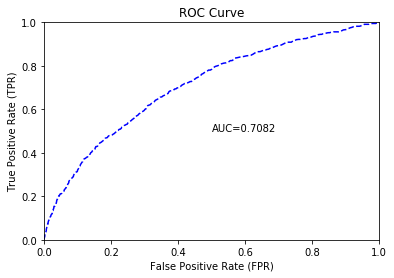

In [61]:
glm_perf = glm_model.model_performance(valid = True)
glm_perf.plot()

#### Standardized Coefficients Plot

We can look at the standardized coefficients plot for our GLM to determine which features had the most influence on  each outcome. We can also get the confusion matrix to see how good our model was at predicting each class.

/Users/navdeepgill/Desktop/pyenv/h2o3_py3.6_env2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


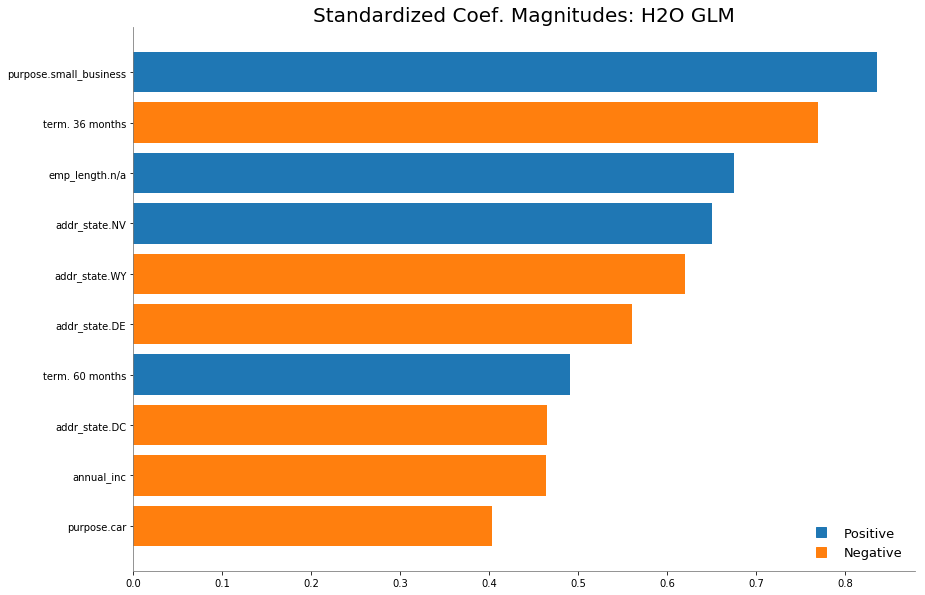

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1997507751132263: 


,Fully Paid,Default,Error,Rate
Fully Paid,3744.0,837.0,0.1827,(837.0/4581.0)
Default,415.0,364.0,0.5327,(415.0/779.0)
Total,4159.0,1201.0,0.2336,(1252.0/5360.0)


In [62]:
glm_model.std_coef_plot(num_of_features = 10)
print(glm_model.confusion_matrix(valid = True))

#### The ROC Curve & Scoring History
**GBM**

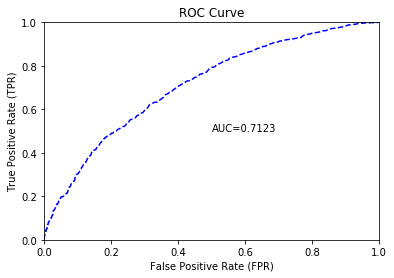

In [63]:
gbm_perf = gbm_model.model_performance(valid = True)
gbm_perf.plot()

Now let's plot the scoring history of our GBM to make sure we weren't overfitting.

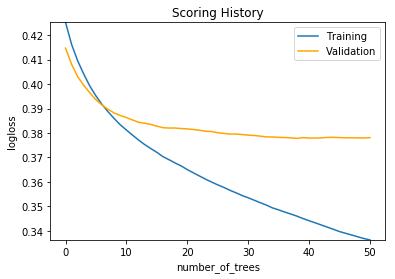

In [64]:
# Plot the scoring history to make sure you're not overfitting
gbm_model.plot()

#### Feature Importance Plot
Take a look at the variable importance for the GBM and generate a confusion matrix for max F1 threshold.

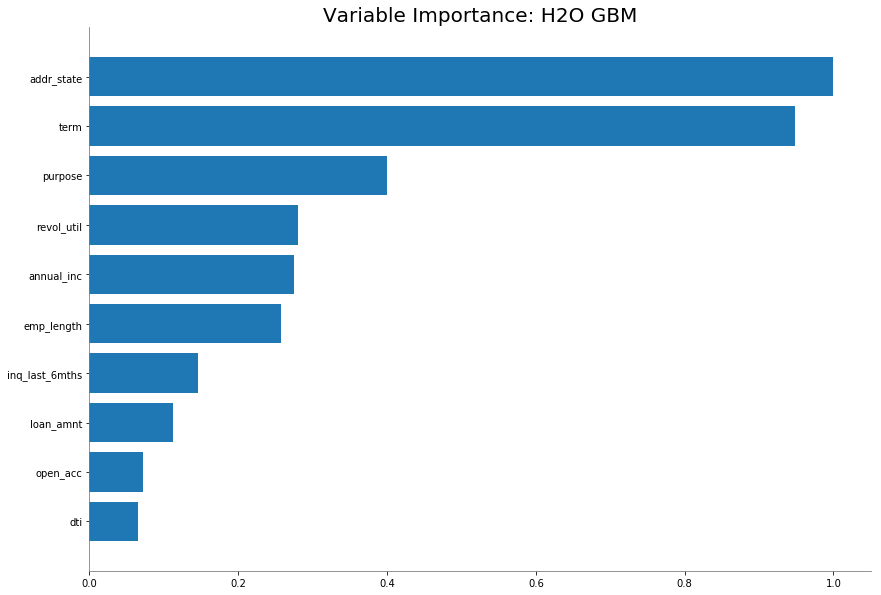

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19267827271475077: 


,Fully Paid,Default,Error,Rate
Fully Paid,3745.0,836.0,0.1825,(836.0/4581.0)
Default,413.0,366.0,0.5302,(413.0/779.0)
Total,4158.0,1202.0,0.233,(1249.0/5360.0)


In [65]:
gbm_model.varimp_plot()
print(gbm_model.confusion_matrix(valid = True))

# Scoring

Use your model to predict on the test dataset (or new data).

In [66]:
pred = gbm_model.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


In [67]:
pred.head(rows=3)

predict,Fully Paid,Default
Fully Paid,0.847003,0.152997
Fully Paid,0.898982,0.101018
Default,0.773261,0.226739


We can verify the cutoff used to decide what will be Fully Paid and what will be Default by looking at the F1 score threshold.

In [68]:
('threshold, F1 score : {0}').format(gbm_model.F1(valid=True)[0])

'threshold, F1 score : [0.19267827271475077, 0.3695103483089349]'

If you want to take a look at the actual results versus what the algo predicted you can cbind the predictions to the  test dataset's prediction column.

In [69]:
test['loan_result'].cbind(pred).head(rows=3)

loan_result,predict,Fully Paid,Default
Fully Paid,Fully Paid,0.847003,0.152997
Fully Paid,Fully Paid,0.898982,0.101018
Fully Paid,Default,0.773261,0.226739


# Saving Models

We can now save our model a binary model that we can use the next time we launch our H2O cluster (note: the saved model must be used with the same version of H2O that it was created with). 

In [70]:
# h2o.save_model(model=gbm_model)

----------------------------------------------------------------------------------------------------------------
# Hands-on Part II<a id='part2'></a>

### Grid Search

Now that we've gone through the process of manually training models, let's learn how to speed up the process and make use of H2O's Grid Search to train a bunch of models.

H2O offers two types of grid search -- `Cartesian` and `RandomDiscrete`. Cartesian is the traditional, exhaustive, grid search, which searches over all the combinations of model hyperparameters. Random Grid Search will sample sets of model hyperparameters randomly for some specified period of time or constraint.

We will continue on with the GBM algorithm to demonstrate H2O's grid search functionality.

### Cartesian Grid Search
We first need to define a grid of GBM model hyperparameters. For this particular example, we will grid over the following model parameters:

* [learn_rate](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/learn_rate.html)
* [max_depth](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/max_depth.html)
* [ntrees](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/algo-params/ntrees.html)

In [71]:
from h2o.grid.grid_search import H2OGridSearch

gbm_hyperparams = {'learn_rate': [.01, .1, .5], 
                'max_depth': [3, 5, 9],
                'ntrees': [50, 200, 500]}

#### Train and validate a grid of GBMs

In [72]:
import time
grid_id_name = 'gbm_cartesian'
model_to_grid = H2OGradientBoostingEstimator(distribution = 'bernoulli', seed=1234)

gbm_grid_cart = H2OGridSearch(model=model_to_grid,
                          grid_id=grid_id_name,
                          hyper_params=gbm_hyperparams)

start = time.time()
gbm_grid_cart.train(x=predictor_columns, y=target, training_frame=train, validation_frame=valid, seed=1234)
end = time.time()

print(end-start)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%
156.60505294799805


#### Compare model performance
To compare the model performance among all the models in a grid, sorted by a particular metric (e.g. AUC), you can use the `get_grid` method.

In [73]:
gbm_grid_cart = gbm_grid_cart.get_grid(sort_by='auc', decreasing=True)

In [74]:
print(gbm_grid_cart)

     learn_rate max_depth ntrees               model_ids                 auc
0          0.01         3    500  gbm_cartesian_model_18  0.7165831745175067
1           0.1         3     50   gbm_cartesian_model_1  0.7165031711324248
2           0.1         3    200  gbm_cartesian_model_10  0.7163965466559846
3          0.01         5    500  gbm_cartesian_model_21  0.7127302619319235
4           0.1         5     50   gbm_cartesian_model_4  0.7122954974767409
5           0.1         3    500  gbm_cartesian_model_19   0.708475931310859
6           0.5         3     50   gbm_cartesian_model_2   0.707145016853953
7          0.01         3    200   gbm_cartesian_model_9  0.7066347325659174
8          0.01         5    200  gbm_cartesian_model_12  0.7066257654614598
9          0.01         5     50   gbm_cartesian_model_3   0.701742896862326
10          0.1         5    200  gbm_cartesian_model_13  0.7011199633245427
11         0.01         3     50   gbm_cartesian_model_0  0.6963766452885293

In [75]:
# get the top model to use
best_model = h2o.get_model(gbm_grid_cart.model_ids[0])
best_model

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_cartesian_model_18


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.11325024427648815
RMSE: 0.33652673634718555
LogLoss: 0.37315504150721474
Mean Per-Class Error: 0.31452935078333666
AUC: 0.7531002800192689
Gini: 0.5062005600385378
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1761464520702621: 


,Fully Paid,Default,Error,Rate
Fully Paid,17190.0,4449.0,0.2056,(4449.0/21639.0)
Default,1704.0,2157.0,0.4413,(1704.0/3861.0)
Total,18894.0,6606.0,0.2413,(6153.0/25500.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1761465,0.4121525,225.0
max f2,0.1202026,0.5480929,289.0
max f0point5,0.2865419,0.4121196,141.0
max accuracy,0.4019588,0.8543137,72.0
max precision,0.7392909,1.0,0.0
max recall,0.0496158,1.0,387.0
max specificity,0.7392909,1.0,0.0
max absolute_mcc,0.2205454,0.2951246,189.0
max min_per_class_accuracy,0.1429810,0.6834881,261.0
max mean_per_class_accuracy,0.1335628,0.6854706,272.0


Gains/Lift Table: Avg response rate: 15.14 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.01,0.4839134,4.4289044,4.4289044,0.6705882,0.6705882,0.0442890,0.0442890,342.8904429,342.8904429
,2,0.02,0.4399643,3.7296037,4.0792541,0.5647059,0.6176471,0.0372960,0.0815851,272.9603730,307.9254079
,3,0.03,0.4038075,3.5483035,3.9022706,0.5372549,0.5908497,0.0354830,0.1170681,254.8303548,290.2270569
,4,0.04,0.3765660,3.0044030,3.6778037,0.4549020,0.5568627,0.0300440,0.1471121,200.4403004,267.7803678
,5,0.05,0.3568678,2.7195027,3.4861435,0.4117647,0.5278431,0.0271950,0.1743072,171.9502720,248.6143486
,6,0.1,0.2927688,2.4864025,2.9862730,0.3764706,0.4521569,0.1243201,0.2986273,148.6402486,198.6272986
,7,0.15,0.2431844,1.9839420,2.6521627,0.3003922,0.4015686,0.0991971,0.3978244,98.3941984,165.2162652
,8,0.2,0.2047999,1.5591816,2.3789174,0.2360784,0.3601961,0.0779591,0.4757835,55.9181559,137.8917379
,9,0.3,0.1616422,1.3131313,2.0236554,0.1988235,0.3064052,0.1313131,0.6070966,31.3131313,102.3655357
,10,0.4,0.1369560,1.0696711,1.7851593,0.1619608,0.2702941,0.1069671,0.7140637,6.9671070,78.5159285




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.11392746030674214
RMSE: 0.3375314212139992
LogLoss: 0.3772159089554665
Mean Per-Class Error: 0.33905350531118794
AUC: 0.7165831745175067
Gini: 0.4331663490350135
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.1799337143948614: 


,Fully Paid,Default,Error,Rate
Fully Paid,3662.0,919.0,0.2006,(919.0/4581.0)
Default,391.0,388.0,0.5019,(391.0/779.0)
Total,4053.0,1307.0,0.2444,(1310.0/5360.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1799337,0.3720038,206.0
max f2,0.1031409,0.5128403,307.0
max f0point5,0.2898730,0.3509956,122.0
max accuracy,0.5141292,0.8569030,17.0
max precision,0.6853600,1.0,0.0
max recall,0.0500415,1.0,387.0
max specificity,0.6853600,1.0,0.0
max absolute_mcc,0.1799337,0.2441496,206.0
max min_per_class_accuracy,0.1376923,0.6572529,255.0
max mean_per_class_accuracy,0.1406474,0.6609465,251.0


Gains/Lift Table: Avg response rate: 14.53 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100746,0.4657955,3.8225645,3.8225645,0.5555556,0.5555556,0.0385109,0.0385109,282.2564541,282.2564541
,2,0.0201493,0.4282946,3.4403081,3.6314363,0.5,0.5277778,0.0346598,0.0731707,244.0308087,263.1436314
,3,0.0300373,0.4052576,2.5964589,3.2907295,0.3773585,0.4782609,0.0256739,0.0988447,159.6458934,229.0729475
,4,0.0401119,0.3788403,2.6757952,3.1362809,0.3888889,0.4558140,0.0269576,0.1258023,167.5795179,213.6280861
,5,0.05,0.3583882,2.0771671,2.9268293,0.3018868,0.4253731,0.0205392,0.1463415,107.7167147,192.6829268
,6,0.1,0.2911373,2.3106547,2.6187420,0.3358209,0.3805970,0.1155327,0.2618742,131.0654685,161.8741977
,7,0.15,0.2401567,1.7458280,2.3277706,0.2537313,0.3383085,0.0872914,0.3491656,74.5827985,132.7770646
,8,0.2,0.1998699,1.5917843,2.1437741,0.2313433,0.3115672,0.0795892,0.4287548,59.1784339,114.3774069
,9,0.3,0.1584837,1.2451861,1.8442448,0.1809701,0.2680348,0.1245186,0.5532734,24.5186136,84.4244758
,10,0.4,0.1348070,1.1296534,1.6655969,0.1641791,0.2420709,0.1129653,0.6662388,12.9653402,66.5596919



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_lift,validation_classification_error
,2018-05-14 09:56:11,1 min 9.487 sec,0.0,0.3584498,0.4251501,0.5,1.0,0.8485882,0.3524915,0.4146778,0.5,1.0,0.8546642
,2018-05-14 09:56:11,1 min 9.501 sec,1.0,0.3582061,0.4244733,0.6764927,3.0007586,0.2554118,0.3522787,0.4140963,0.6634224,2.6381637,0.2694030
,2018-05-14 09:56:11,1 min 9.513 sec,2.0,0.3579671,0.4238154,0.6770536,3.0007586,0.2649412,0.3520625,0.4135102,0.6653565,2.6381637,0.2615672
,2018-05-14 09:56:11,1 min 9.526 sec,3.0,0.3577326,0.4231754,0.6770536,3.0007586,0.2649412,0.3518585,0.4129611,0.6653565,2.6381637,0.2615672
,2018-05-14 09:56:11,1 min 9.537 sec,4.0,0.3575026,0.4225525,0.6771438,3.0007586,0.2692941,0.3516556,0.4124189,0.6654534,2.6381637,0.2664179
---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2018-05-14 09:56:15,1 min 13.349 sec,144.0,0.3442183,0.3911656,0.7228695,4.0584945,0.2688235,0.3408493,0.3862275,0.7032725,3.4403081,0.2503731
,2018-05-14 09:56:15,1 min 13.387 sec,145.0,0.3441818,0.3910859,0.7229629,4.0623946,0.2696863,0.3408238,0.3861688,0.7032735,3.4403081,0.2554104
,2018-05-14 09:56:15,1 min 13.423 sec,146.0,0.3441465,0.3910075,0.7230369,4.1020178,0.2701176,0.3408003,0.3861089,0.7034003,3.4403081,0.2513060
,2018-05-14 09:56:15,1 min 13.463 sec,147.0,0.3441120,0.3909268,0.7230689,4.0860566,0.2632157,0.3407881,0.3860715,0.7032704,3.4403081,0.2516791



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
term,8151.7578125,1.0,0.4361770
addr_state,2948.3635254,0.3616844,0.1577584
annual_inc,1775.1832275,0.2177669,0.0949849
revol_util,1765.9587402,0.2166353,0.0944913
purpose,1698.1835938,0.2083212,0.0908649
inq_last_6mths,951.2167969,0.1166885,0.0508969
emp_length,362.4564819,0.0444636,0.0193940
pub_rec,231.0276337,0.0283408,0.0123616
loan_amnt,208.1590729,0.0255355,0.0111380
open_acc,153.2784882,0.0188031,0.0082015


## Random Grid Search
This example is set to run fairly quickly -- increase `max_runtime_secs` or `max_models` to cover more of the hyperparameter space. Also, you can expand the hyperparameter space of each of the algorithms by modifying the hyper parameter list below.

In [76]:
grid_id_name_rand = 'gbm_random'

gbm_hyperparams_rand = {'learn_rate': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1], 
                'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                'ntrees': [50, 100, 200, 500, 1000]}

the `search_criteria` parameter allows you to pass a dictionary of directives which control the search of the hyperparameter space. The default strategy “Cartesian” covers the entire space of hyperparameter combinations. Specify the “RandomDiscrete” strategy to get random search of all the combinations of your hyperparameters. `RandomDiscrete` should usually be combined with at least one early stopping criterion: max_models and/or max_runtime_secs

In [77]:
search_criteria = {'strategy': 'RandomDiscrete', 'max_runtime_secs': 30}

#### Train and validate a random grid of GBMs

In [78]:
gbm_grid_rand = H2OGridSearch(model=model_to_grid,
                              grid_id=grid_id_name_rand,
                              hyper_params=gbm_hyperparams_rand,
                              search_criteria=search_criteria)

gbm_grid_rand.train(x=predictor_columns, y=target, training_frame=train, validation_frame=valid, seed=1234)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


#### Compare model performance¶

In [79]:
gbm_grid_rand = gbm_grid_rand.get_grid(sort_by='auc', decreasing=True)
print(gbm_grid_rand)

    learn_rate max_depth ntrees           model_ids                 auc
0         0.02         5    500  gbm_random_model_0  0.7130308000422575
1         0.01         4    200  gbm_random_model_2  0.7090903180772062
2         0.03         6   1000  gbm_random_model_1  0.6903190860054604
3         0.04        10    200  gbm_random_model_3  0.6800004707729841



--------------------------------------------------------------------------------------------------------------
# AutoML<a id='automl'></a>

After all the hard manual labor above, we will now see how we can automate our previous work with AutoML.

Read more about AutoML in the [docs](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html).

*The H2O AutoML interface is designed to have as few parameters as possible so that all the user needs to do is point to their dataset, identify the response column and optionally specify a time constraint or limit on the number of total models trained.* 

Note: by default AutoML will run cross-validation for all models, and therefore use the cross-validation metrics to generate the leaderboard results.

In [80]:
from h2o.automl import H2OAutoML

automl = H2OAutoML(max_runtime_secs = 60, seed = 12345)

automl.train(x = predictor_columns, y = target, training_frame = loan_stats)

AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


Print out the leaderboard (the leaderboard is a table that ranks your models by a default metric based on the problem type (the second column of the leaderboard). In binary classification problems, that metric is AUC, and in multiclass classification problems, the metric is mean per-class error. In regression problems, the default sort metric is deviance. Some additional metrics are also provided, for convenience.

In [81]:
automl.leaderboard

model_id,auc,logloss
StackedEnsemble_AllModels_0_AutoML_20180514_095954,0.720538,0.385208
StackedEnsemble_BestOfFamily_0_AutoML_20180514_095954,0.720446,0.385248
GLM_grid_0_AutoML_20180514_095954_model_0,0.715088,0.384592
GBM_grid_0_AutoML_20180514_095954_model_0,0.709547,0.387792
GBM_grid_0_AutoML_20180514_095954_model_1,0.703459,0.389711
GBM_grid_0_AutoML_20180514_095954_model_2,0.696283,0.391423
DRF_0_AutoML_20180514_095954,0.689586,0.410104
XRT_0_AutoML_20180514_095954,0.68409,0.398843


Print the results of the leader model

In [82]:
print(automl.leader)

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_0_AutoML_20180514_095954
No model summary for this model


ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.07652721851018394
RMSE: 0.27663553370849514
LogLoss: 0.26685295028426576
Null degrees of freedom: 28966
Residual degrees of freedom: 28960
Null deviance: 24489.05483216992
Residual deviance: 15459.85882176865
AIC: 15473.85882176865
AUC: 0.9594435973180309
Gini: 0.9188871946360617
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20663361204308228: 


,Fully Paid,Default,Error,Rate
Fully Paid,22618.0,2004.0,0.0814,(2004.0/24622.0)
Default,803.0,3542.0,0.1848,(803.0/4345.0)
Total,23421.0,5546.0,0.0969,(2807.0/28967.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2066336,0.7162067,243.0
max f2,0.1558562,0.8211505,279.0
max f0point5,0.3668002,0.7477783,157.0
max accuracy,0.2972102,0.9145925,190.0
max precision,0.9289539,1.0,0.0
max recall,0.0978745,1.0,340.0
max specificity,0.9289539,1.0,0.0
max absolute_mcc,0.2066336,0.6659493,243.0
max min_per_class_accuracy,0.1796721,0.8874990,261.0
max mean_per_class_accuracy,0.1502642,0.9015038,283.0


Gains/Lift Table: Avg response rate: 15.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100114,0.6983370,6.6667434,6.6667434,1.0,1.0,0.0667434,0.0667434,566.6743383,566.6743383
,2,0.0200228,0.6238288,6.4138669,6.5403051,0.9620690,0.9810345,0.0642117,0.1309551,541.3866910,554.0305147
,3,0.0299997,0.5597307,6.3899236,6.4902933,0.9584775,0.9735328,0.0637514,0.1947066,538.9923589,549.0293328
,4,0.0400110,0.5101981,6.0230578,6.3733837,0.9034483,0.9559965,0.0602992,0.2550058,502.3057815,537.3383666
,5,0.0500224,0.4668628,5.7701813,6.2526599,0.8655172,0.9378882,0.0577675,0.3127733,477.0181342,525.2659943
,6,0.1000104,0.3234354,4.6731661,5.4631856,0.7009669,0.8194684,0.2336018,0.5463751,367.3166115,446.3185637
,7,0.1499983,0.2444197,3.0893542,4.6720906,0.4633978,0.7008055,0.1544304,0.7008055,208.9354151,367.2090587
,8,0.2000207,0.1994899,2.6225285,4.1595232,0.3933747,0.6239213,0.1311853,0.8319908,162.2528453,315.9523184
,9,0.2999965,0.1409562,1.4295745,3.2497497,0.2144337,0.4874568,0.1429229,0.9749137,42.9574462,224.9749709
,10,0.4000069,0.1142869,0.2324270,2.4953539,0.0348637,0.3742988,0.0232451,0.9981588,-76.7572978,149.5353936




ModelMetricsBinomialGLM: stackedensemble
** Reported on validation data. **

MSE: 0.11530195187296831
RMSE: 0.3395614110480876
LogLoss: 0.38121849288061443
Null degrees of freedom: 7317
Residual degrees of freedom: 7311
Null deviance: 6184.341748868599
Residual deviance: 5579.513861800673
AIC: 5593.513861800673
AUC: 0.7219206507437903
Gini: 0.4438413014875806
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.16113929541924737: 


,Fully Paid,Default,Error,Rate
Fully Paid,4964.0,1257.0,0.2021,(1257.0/6221.0)
Default,509.0,588.0,0.464,(509.0/1097.0)
Total,5473.0,1845.0,0.2413,(1766.0/7318.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1611393,0.3997281,253.0
max f2,0.0969445,0.5141504,337.0
max f0point5,0.2772900,0.3873157,169.0
max accuracy,0.5746908,0.8535119,41.0
max precision,0.8312834,1.0,0.0
max recall,0.0625864,1.0,394.0
max specificity,0.8312834,1.0,0.0
max absolute_mcc,0.1611393,0.2745387,253.0
max min_per_class_accuracy,0.1268983,0.6590702,292.0
max mean_per_class_accuracy,0.1305411,0.6676345,288.0


Gains/Lift Table: Avg response rate: 14.99 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0101121,0.5798216,4.2369361,4.2369361,0.6351351,0.6351351,0.0428441,0.0428441,323.6936116,323.6936116
,2,0.0200875,0.4999921,3.0156217,3.6304330,0.4520548,0.5442177,0.0300820,0.0729262,201.5621683,263.0433030
,3,0.0300629,0.4471947,3.1983866,3.4870722,0.4794521,0.5227273,0.0319052,0.1048314,219.8386634,248.7072180
,4,0.0400383,0.4123331,3.1070042,3.3923795,0.4657534,0.5085324,0.0309936,0.1358250,210.7004158,239.2379465
,5,0.0500137,0.3817369,1.9190320,3.0985151,0.2876712,0.4644809,0.0191431,0.1549681,91.9031980,209.8515076
,6,0.1000273,0.2885051,2.5152652,2.8068901,0.3770492,0.4207650,0.1257976,0.2807657,151.5265179,180.6890128
,7,0.1500410,0.2276695,1.8408825,2.4848876,0.2759563,0.3724954,0.0920693,0.3728350,84.0882486,148.4887580
,8,0.2000547,0.1864536,1.6768435,2.2828765,0.2513661,0.3422131,0.0838651,0.4567001,67.6843453,128.2876549
,9,0.3000820,0.1462716,1.2029529,1.9229020,0.1803279,0.2882514,0.1203282,0.5770283,20.2952912,92.2902003
,10,0.3999727,0.1231882,0.9673291,1.6842536,0.1450068,0.2524769,0.0966272,0.6736554,-3.2670871,68.4253636




ModelMetricsBinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.11697781013210987
RMSE: 0.3420201896556837
LogLoss: 0.38520845531154035
Null degrees of freedom: 28966
Residual degrees of freedom: 28960
Null deviance: 24491.259839400507
Residual deviance: 22316.66665001878
AIC: 22330.66665001878
AUC: 0.7205381782213349
Gini: 0.44107635644266985
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15879079269296167: 


,Fully Paid,Default,Error,Rate
Fully Paid,19233.0,5389.0,0.2189,(5389.0/24622.0)
Default,2036.0,2309.0,0.4686,(2036.0/4345.0)
Total,21269.0,7698.0,0.2563,(7425.0/28967.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.1587908,0.3834593,263.0
max f2,0.1027121,0.5251605,330.0
max f0point5,0.2474702,0.3579116,196.0
max accuracy,0.6653537,0.8509338,29.0
max precision,0.7923246,0.7,8.0
max recall,0.0615328,1.0,395.0
max specificity,0.8834796,0.9999594,0.0
max absolute_mcc,0.1587908,0.2526435,263.0
max min_per_class_accuracy,0.1255816,0.6591484,298.0
max mean_per_class_accuracy,0.1225102,0.6602069,302.0


Gains/Lift Table: Avg response rate: 15.00 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100114,0.5915413,3.4253268,3.4253268,0.5137931,0.5137931,0.0342923,0.0342923,242.5326773,242.5326773
,2,0.0200228,0.5093346,3.2873942,3.3563605,0.4931034,0.5034483,0.0329114,0.0672037,228.7394151,235.6360462
,3,0.0299997,0.4605585,2.8374029,3.1837727,0.4256055,0.4775604,0.0283084,0.0955121,183.7402893,218.3772732
,4,0.0400110,0.4203572,2.5517535,3.0256316,0.3827586,0.4538395,0.0255466,0.1210587,155.1753502,202.5631596
,5,0.0500224,0.3911472,2.6437086,2.9491943,0.3965517,0.4423741,0.0264672,0.1475259,164.3708583,194.9194278
,6,0.1000104,0.2924628,2.2283866,2.5889148,0.3342541,0.3883328,0.1113924,0.2589183,122.8386600,158.8914845
,7,0.1499983,0.2301023,1.8968911,2.3582933,0.2845304,0.3537399,0.0948216,0.3537399,89.6891073,135.8293344
,8,0.2000207,0.1902187,1.6011226,2.1689353,0.2401656,0.3253366,0.0800921,0.4338320,60.1122634,116.8935326
,9,0.2999965,0.1459867,1.3605129,1.8995232,0.2040746,0.2849252,0.1360184,0.5698504,36.0512893,89.9523201
,10,0.4000069,0.1230340,1.0102521,1.6771862,0.1515361,0.2515750,0.1010357,0.6708861,1.0252104,67.7186240


You can now use the `automl` object to make predictions using the best model. *note: the test frame was used during training so this is just an illustration of how you could pass in a new dataset on which to predict.* 

In [83]:
automl.leader.predict(test_data=test)

stackedensemble prediction progress: |████████████████████████████████████| 100%


predict,Fully Paid,Default
Fully Paid,0.902802,0.0971984
Fully Paid,0.898121,0.101879
Fully Paid,0.843711,0.156289
Default,0.815175,0.184825
Fully Paid,0.917239,0.0827615
Fully Paid,0.884449,0.115551
Fully Paid,0.900687,0.0993129
Fully Paid,0.913747,0.0862527
Fully Paid,0.925306,0.0746941
Fully Paid,0.894292,0.105708


# Shutdown Your H2O Cluster

In [84]:
h2o.cluster().shutdown()

H2O session _sid_b790 closed.
